#### Black Friday Prediction EDA

#### fearures description
    User_ID	                         User ID
    Product_ID	                     Product ID
    Gender	                         Sex of User
    Age	                             Age in bins
    Occupation	                     Occupation (Masked)
    City_Category	                 Category of the City (A,B,C)
    Stay_In_Current_City_Years	     Number of years stay in current city
    Marital_Status	                 Marital Status
    Product_Category_1	             Product Category (Masked)
    Product_Category_2	             Product may belongs to other category also (Masked)
    Product_Category_3	             Product may belongs to other category also (Masked)
    Purchase	                     Purchase Amount (Target Variable)
#### Evaluation Metric : RMSE

In [1]:
# Importing the required Packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime, date, time
#from pandas_profiling import ProfileReport
import joblib
# to display all columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import figure
from pylab import rcParams
import scipy.stats as stats
from scipy.stats import shapiro

#### Importing Training Dataset

In [3]:
# training dataset ####
train_data = pd.read_csv("C:\\Users\\krupakar\\Desktop\\ML Assignments\\Black_Friday_Sales_Prediction\\datasets\\train.csv")
print(train_data.shape)
X_train = train_data.copy()
print(X_train.shape)

(550068, 12)
(550068, 12)


In [4]:
# features names
X_train.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase'],
      dtype='object')

In [5]:
# drop duplicate rows 
X_train = X_train.drop_duplicates(keep = 'first')
X_train.shape

(550068, 12)

#### Observations : no duplicate records

In [6]:
# features datatypes
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550068 entries, 0 to 550067
Data columns (total 12 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null object
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int64
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            376430 non-null float64
Product_Category_3            166821 non-null float64
Purchase                      550068 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 54.6+ MB


In [7]:
# checking nan values columns
X_train.isna().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

#### Observations: 
    1. Product_Category_2 (31.5%) and Product_Category_3 (69.6%) has nan values

In [8]:
# distinct values count of each feature
X_train.nunique()

User_ID                        5891
Product_ID                     3631
Gender                            2
Age                               7
Occupation                       21
City_Category                     3
Stay_In_Current_City_Years        5
Marital_Status                    2
Product_Category_1               20
Product_Category_2               17
Product_Category_3               15
Purchase                      18105
dtype: int64

#### Observations : 
    1. Total no of users or customers for last month are 5891 in all locations
    2. Total no of distinct products purchased by 5891 users are 3631
    3. 3631 products are categorised into 3 different categories 

### Explanatory Data Analysis

#### 1. Purchase - Target feature

In [9]:
# Purchase Analysis
X_train['Purchase'].describe()

count    550068.000000
mean       9263.968713
std        5023.065394
min          12.000000
25%        5823.000000
50%        8047.000000
75%       12054.000000
max       23961.000000
Name: Purchase, dtype: float64

In [10]:
# skewness 
X_train['Purchase'].skew()

0.6001400037087128

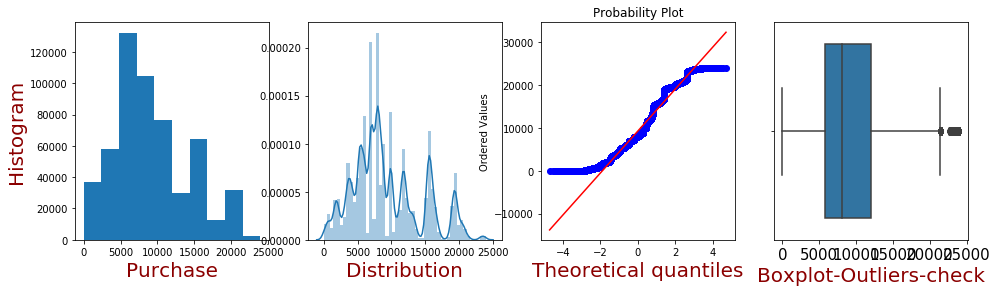

In [11]:
# Purchase plots
plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
plt.hist(X_train['Purchase'])
plt.xlabel("Purchase", fontsize = 20,  color = 'darkred')
plt.ylabel("Histogram", fontsize = 20, color = 'darkred')

plt.subplot(1,4,2)
sns.distplot(X_train['Purchase'] )
plt.xlabel("Distribution", fontsize = 20, color = 'darkred')

plt.subplot(1,4,3)
stats.probplot(X_train['Purchase'], dist= 'norm', plot= plt)
plt.xlabel("Theoretical quantiles", fontsize = 20, color = 'darkred')

plt.subplot(1,4,4)
sns.boxplot(X_train['Purchase'])
plt.xlabel("Boxplot-Outliers-check", fontsize = 20,  color = 'darkred')

plt.xticks(fontsize = 15)

plt.show()

#### Normality Statistical Test

In [12]:
# Null Hypothesis : Follows Gaussian Distribution
# Alternate Hypothesis : Doesn't follow Gaussian Distribution
# Significance level : 0.05
np.random.seed(1234)
for i in range(10) :
    stats, pval = shapiro(X_train['Purchase'].sample(30))
    print(stats, pval)

0.9185457825660706 0.024593433365225792
0.9347015619277954 0.06554069370031357
0.9242467880249023 0.03461362048983574
0.8624206781387329 0.0011412394233047962
0.9559701085090637 0.24353790283203125
0.937418520450592 0.07751642167568207
0.9314860105514526 0.05378114804625511
0.9374213218688965 0.07752993702888489
0.9245416522026062 0.03523566946387291
0.9320136308670044 0.05555069074034691


#### Observations :
    1. Moderately right skewed data
    2. Presence of few outliers
    3. Data follows approximately Gaussian Distribution

#### 2. Product Id

In [13]:
# saperating the product id's numeric and string values
X_train['Product_ID_n'] = X_train['Product_ID'].str.replace('([A-Za-z]+)', '').astype(int)
X_train['Product_ID_s'] = X_train['Product_ID'].str.extract('([A-Za-z]+)')
print(X_train.shape )

(550068, 14)


In [14]:
# Handling Rare Labels Function
def f_find_frequent_labels (dataset, var, threshold) :
    tmp = dataset.groupby([var]).size()/dataset.shape[0]
    frequent_ls = tmp[tmp > threshold].index
    return frequent_ls

In [15]:
# Handling rare labels of Product categories based on Frequency distribution ####
freq_products_lst = f_find_frequent_labels(X_train, "Product_ID_n", 0.0001)
len(freq_products_lst)

2005

In [16]:
#### Handling Rare labels for Product ID #####
X_train["Product_ID_Rare"] = np.where(X_train["Product_ID_n"].isin(freq_products_lst), X_train["Product_ID_n"], 0000 )
X_train.shape

(550068, 15)

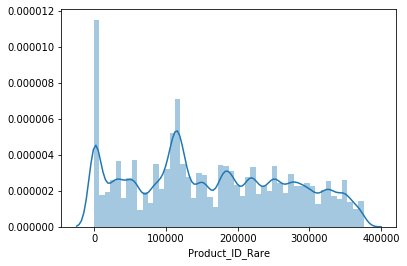

In [17]:
# distribution of product_id_rare
sns.distplot(X_train["Product_ID_Rare"])
plt.show()

#### 3. Gender

Gender based total no of purchases : 


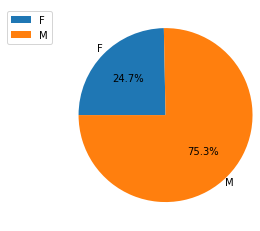

In [18]:
# Gender Analysis
plt.figure(figsize=(8,4))
print("Gender based total no of purchases : ")
labels = X_train.groupby(['Gender']).size().index
plt.pie(X_train.groupby(['Gender']).size()/X_train.shape[0] * 100, autopct='%1.1f%%',  labels= labels)
plt.legend()
plt.xlim(1.5)
plt.show()

Gender based Percentage of Unique Users: 


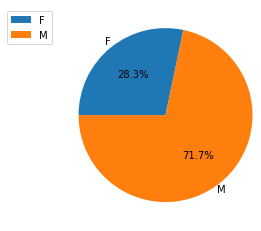

In [19]:
# Gender Unique users
plt.figure(figsize=(8,4))
print("Gender based Percentage of Unique Users: ")
labels = X_train.groupby(['Gender'])['User_ID'].nunique().index
plt.pie(X_train.groupby(['Gender'])['User_ID'].nunique()/5891 * 100, autopct='%1.1f%%',  labels= labels)
plt.legend()
plt.xlim(1.5)
plt.show()

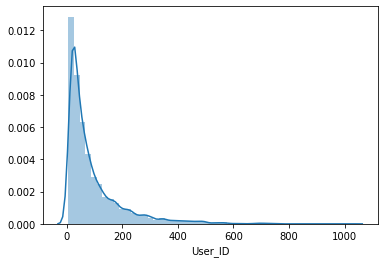

skewness of the users purchase distribution : 2.6006374899031646


In [20]:
# users count purchase distribution
sns.distplot(X_train['User_ID'].value_counts())
plt.show()
print("skewness of the users purchase distribution :", X_train['User_ID'].value_counts().skew())

#### Observations :
    1. 24.7% of the purchases are done by females
    2. 75.3% of the purchases are done by men
    3. 28.3% unique Female users
    4. 71.7% unique Male users

#### 4. Age

Percentage of Age category purchasers: 


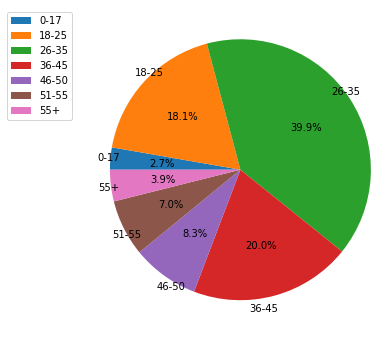

In [21]:
#  Age Visualization
plt.figure(figsize=(8,6))
print("Percentage of Age category purchasers: ")
labels = X_train.groupby(['Age'])['Age'].count().index
plt.pie(X_train.groupby(['Age'])['Age'].count()/X_train.shape[0] * 100, autopct='%1.1f%%',  labels= labels)
plt.legend() ; plt.xlim(1.5) ; plt.show()

#### Observations :
    1. 40% of the purchasers are between 26-35yrs category
    2. 20% of the purchasers are between 36-45yrs category
    3. 18% of the purchasers are between 18-25yrs category
    4. Below 18yrs and above 45yrs categories are less purchasers

#### 5. Occupation

4     13.145284
0     12.659889
7     10.750125
1      8.621843
17     7.279645
20     6.101427
12     5.668208
14     4.964659
2      4.833584
16     4.612339
6      3.700452
3      3.208694
10     2.350618
5      2.213726
15     2.211545
11     2.106285
19     1.538173
13     1.404917
18     1.203851
9      1.143677
8      0.281056
Name: Occupation, dtype: float64


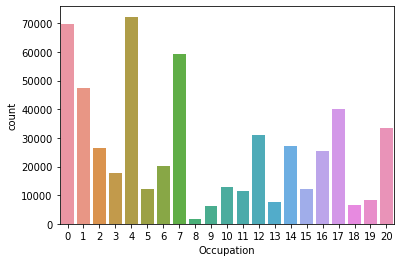

In [22]:
# Occupation Analysis
print(X_train['Occupation'].value_counts()/X_train.shape[0] * 100)
sns.countplot(X_train['Occupation'])
plt.show()

#### Observations:
    1. Occupations 0, 4 and 7 categories has more than 10% purchases
    2. Occupations 8, 9, 13, 18 and 19 categories has less than 2% purchases

#### 6. City_Category

Percentage of City Category purchasers: 


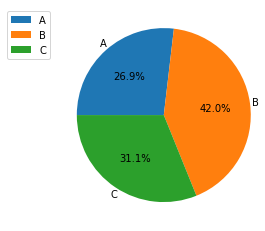

In [23]:
#  City Category Visualization
plt.figure(figsize=(8,4))
print("Percentage of City Category purchasers: ")
labels = X_train.groupby(['City_Category'])['City_Category'].count().index
plt.pie(X_train.groupby(['City_Category'])['City_Category'].count()/X_train.shape[0] * 100, autopct='%1.1f%%',  labels= labels)
plt.legend() ; plt.xlim(1.5) ; plt.show()

#### Observations :
    1. 42% of the purchases are from City Category - B
    2. 26.9% of the purchases are from City Category - A

#### 7. Current City Stay Period

Percentage of Current City Stay Period purchasers: 


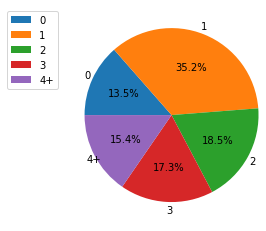

In [24]:
#  Current City Stay Period Visualization
plt.figure(figsize=(8,4))
print("Percentage of Current City Stay Period purchasers: ")
labels = X_train.groupby(['Stay_In_Current_City_Years'])['Stay_In_Current_City_Years'].count().index
plt.pie(X_train.groupby(['Stay_In_Current_City_Years'])['Stay_In_Current_City_Years'].count()/X_train.shape[0] * 100, autopct='%1.1f%%',  labels= labels)
plt.legend() ; plt.xlim(1.5) ; plt.show()

#### Observations :
    1. Users who staying the current ciy between 1 & 2 yrs are highest purchasers with 36.2%
    2. Users who staying the current ciy less tahn 1 yr are lowest purchasers with 13.5%

#### 8. Marital Status

Percentage of Marital Status purchasers: 


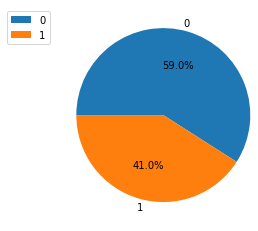

In [25]:
# Marital Status Visualization
plt.figure(figsize=(8,4))
print("Percentage of Marital Status purchasers: ")
labels = X_train.groupby(['Marital_Status'])['Marital_Status'].count().index
plt.pie(X_train.groupby(['Marital_Status'])['Marital_Status'].count()/X_train.shape[0] * 100, autopct='%1.1f%%',  labels= labels)
plt.legend() ; plt.xlim(1.5) ; plt.show()

#### Observations :
    1. 59% of the Purchasers are Unmarried
    2. 41% of the purchasers are Married

#### 9. Product Category 1               

In [26]:
# Handling rare labels of Product category 1 groups based on Frequency distribution ####
freq_prod_category1_lst = f_find_frequent_labels(X_train, "Product_Category_1", 0.01)
len(freq_prod_category1_lst)

11

In [27]:
#### Handling Rare labels for Product Category 1 #####
X_train["Product_Category_1_Rare"] = np.where(X_train["Product_Category_1"].isin(freq_prod_category1_lst), X_train["Product_Category_1"], 0000 )
X_train.shape

(550068, 16)

Percentage of Product Category 1 sales: 


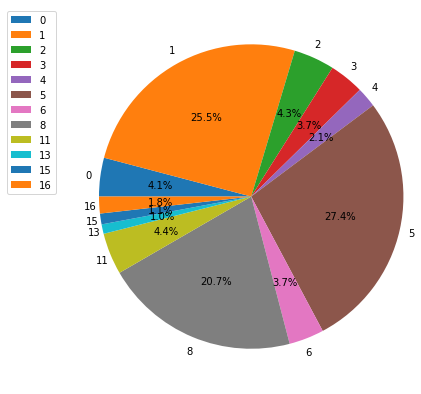

In [28]:
# Product Category 1 Rare Visualization
plt.figure(figsize=(8,7))
print("Percentage of Product Category 1 sales: ")
labels = X_train.groupby(['Product_Category_1_Rare'])['Product_Category_1_Rare'].count().index
plt.pie(X_train.groupby(['Product_Category_1_Rare'])['Product_Category_1_Rare'].count()/X_train.shape[0] * 100, autopct='%1.1f%%',  labels= labels)
plt.legend() ; plt.xlim(1.5) ; plt.show()

#### Observations :
    1. Groups 1, 5 and 8 categories has higher sales percent i.e. 20+% in Product Category 1
    2. Rest all other groups has less than 5% sales    

#### 10. Product Category 2        

In [29]:
# Handling rare labels of Product category 2 groups based on Frequency distribution ####
freq_prod_category2_lst = f_find_frequent_labels(X_train, "Product_Category_2", 0.01)
len(freq_prod_category2_lst)

13

In [30]:
#### Handling Rare labels for Product Category 2 #####
X_train["Product_Category_2_Rare"] = np.where(X_train["Product_Category_2"].isin(freq_prod_category2_lst), X_train["Product_Category_2"], 0000 )
X_train.shape

(550068, 17)

Percentage of Product Category 2 sales: 


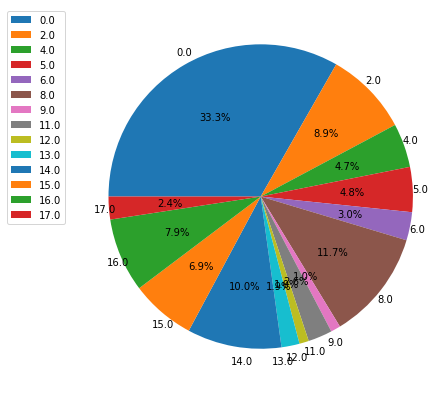

In [31]:
# Product Category 2 Rare Visualization
plt.figure(figsize=(8,7))
print("Percentage of Product Category 2 sales: ")
labels = X_train.groupby(['Product_Category_2_Rare'])['Product_Category_2_Rare'].count().index
plt.pie(X_train.groupby(['Product_Category_2_Rare'])['Product_Category_2_Rare'].count()/X_train.shape[0] * 100, autopct='%1.1f%%',  labels= labels)
plt.legend() ; plt.xlim(1.5) ; plt.show()

#### Observations :
    1. "Others" group has 33.3% sales in Product Category 2
    2. Groups 8, 14 has 11.7% and 10% sales in Product Category 2
    3. Rest of the groups has less than 10% sales

#### 11. Product Category 3      

In [32]:
# Handling rare labels of Product category 3 groups based on Frequency distribution ####
freq_prod_category3_lst = f_find_frequent_labels(X_train, "Product_Category_3", 0.01)
len(freq_prod_category3_lst)

8

In [33]:
#### Handling Rare labels for Product Category 2 #####
X_train["Product_Category_3_Rare"] = np.where(X_train["Product_Category_3"].isin(freq_prod_category3_lst), X_train["Product_Category_3"], 0000 )
X_train.shape

(550068, 18)

Percentage of Product Category 3 sales: 


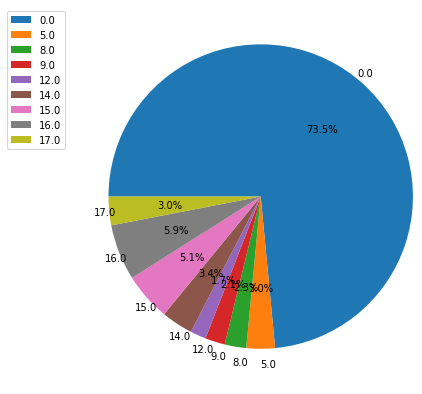

In [34]:
# Product Category 2 Rare Visualization
plt.figure(figsize=(8,7))
print("Percentage of Product Category 3 sales: ")
labels = X_train.groupby(['Product_Category_3_Rare'])['Product_Category_3_Rare'].count().index
plt.pie(X_train.groupby(['Product_Category_3_Rare'])['Product_Category_3_Rare'].count()/X_train.shape[0] * 100, autopct='%1.1f%%',  labels= labels)
plt.legend() ; plt.xlim(1.5) ; plt.show()

#### Observations :
    1. "Others" group has 73.5% sales in Product Category 3
    2. Rest of the groups has less than 6% sales in Product Category 3

#### One Hot Encoder

In [35]:
# Gender Encoder
X_train['Gender_le'] = np.where(X_train['Gender'] == 'M', 1, 0)
X_train.shape

(550068, 19)

In [36]:
# City Category one hot encoding
ohe_city = pd.get_dummies(X_train['City_Category'], prefix= 'ohe_city')
# adding the onehot encoding columns to X_train dataset 
X_train = X_train.merge(ohe_city, left_index= True, right_index= True)
X_train.shape

(550068, 22)

In [37]:
# features
X_train.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase', 'Product_ID_n',
       'Product_ID_s', 'Product_ID_Rare', 'Product_Category_1_Rare',
       'Product_Category_2_Rare', 'Product_Category_3_Rare', 'Gender_le',
       'ohe_city_A', 'ohe_city_B', 'ohe_city_C'],
      dtype='object')

#### Pickling

In [38]:
# pickling train dataset for further processing ####
print(X_train.shape)
print(joblib.dump(X_train, "df_train_eda.pkl")) 

(550068, 22)
['df_train_eda.pkl']


In [39]:
# pickling frequent labels for category features
print(joblib.dump((freq_products_lst, freq_prod_category1_lst, freq_prod_category2_lst, freq_prod_category3_lst), "frequent_labels.pkl"))

['frequent_labels.pkl']


### Comments are appreciated to improve model and learning !!!